In [1]:
from utils import *
from sklearn.metrics import roc_curve, roc_auc_score,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150

In [2]:
set_seed(0)

Random seed set as 0


In [3]:
X_train = np.load('./classification_data/X_train.npy')
X_val = np.load('./classification_data/X_val.npy')
X_test = np.load('./classification_data/X_test.npy')
y_train = np.load('./classification_data/y_train.npy')
y_val = np.load('./classification_data/y_val.npy')
y_test = np.load('./classification_data/y_test.npy')
bcu_samples = np.load('./classification_data/bcu_samples.npy')

In [4]:
def soft_voting_predictions(X, epochs, weights, model):
    preds = np.zeros((X.shape[0], 1))
    for epoch, weight in zip(epochs, weights):
        weights_path = f"./checkpoints_classifier_379_params/weights_epoch_{epoch}.h5"
        model.load_weights(weights_path)
        predictions = model.predict(X)
        preds += weight * predictions

    preds /= np.sum(weights)
    return preds

def plot_histograms(bin_centers, hist, label, title):
    bar_width = bin_centers[1] - bin_centers[0]
    plt.bar(bin_centers, hist, width=bar_width, alpha=0.6, color='tab:blue', label=label)
    plt.title(title)
    plt.xlabel('Probabilities')
    plt.ylabel('Count')
    plt.legend()


def create_and_plot_histograms_cm_and_roc(model, X, title, mode, epochs = None, weights = None, cm_roc = None):
    sns.set(style="darkgrid")
    # Compute soft voting predictions
    if mode == 'greedy' or mode == 'ssl':
        predictions = model.predict(X, verbose= 0)
    else:
        predictions = soft_voting_predictions(X, epochs, weights, model)
    # Calculate bin edges and centers
    no_of_bins = 20  # Adjust as needed
    hist_predictions, bin_edges_predictions = np.histogram(predictions, bins=no_of_bins)
    bar_width_predictions = bin_edges_predictions[1] - bin_edges_predictions[0]
    bin_centers_predictions = bin_edges_predictions[:-1] + bar_width_predictions / 2

    # Create and plot histograms
    plt.figure(figsize=(6, 4))
    plt.bar(bin_centers_predictions, hist_predictions, width=bar_width_predictions, alpha=0.6, color='tab:blue', label='Predictions')
    plt.title(title)
    plt.xlabel('Probabilities')
    plt.ylabel('Count')
    plt.legend()
    plt.show()
    if cm_roc == True:
        roc_auc  =  roc_auc_score(y_test, predictions)
        plot_confusion_matrix_and_roc(y_test, predictions, roc_auc)


def plot_confusion_matrix_and_roc(y_true, y_pred, roc_auc):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random Guessing (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    sns.set(style="dark")
    cm = confusion_matrix(y_true, np.round(y_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['BLL', 'FSRQ'])
    disp.plot()
    plt.show()
    print(classification_report(y_true, np.round(y_pred), digits=3))


### Bias initialisation + Ensembled soft voting


1053
551
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 42)                336       
_________________________________________________________________
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 43        
Total params: 379
Trainable params: 379
Non-trainable params: 0
_________________________________________________________________


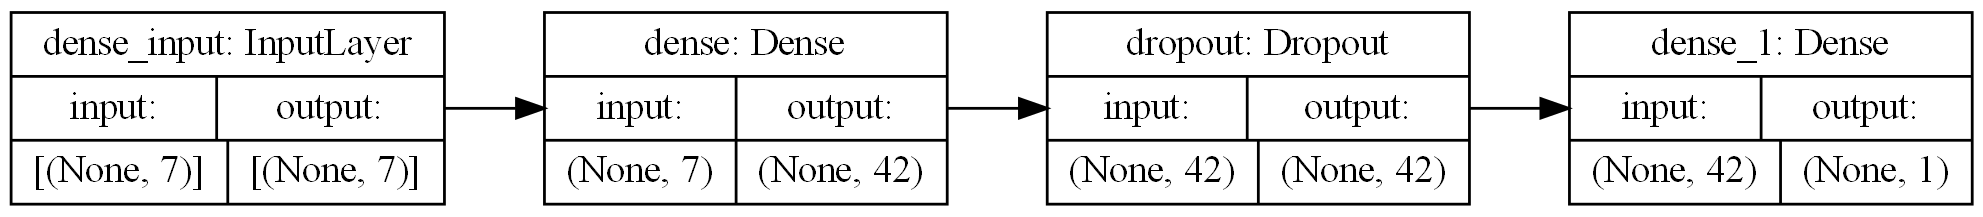

In [5]:
bll, fsrq = np.bincount(y_train)
print(bll)
print(fsrq)
output_bias = tf.keras.initializers.Constant(np.log([fsrq/bll]))
standard_nn_classifier = tf.keras.models.Sequential([
            tf.keras.layers.Dense(42, activation='relu', input_shape = (X_train.shape[1],)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer = output_bias)
        ])
standard_nn_classifier.summary()

tf.keras.utils.plot_model(
    standard_nn_classifier,
    to_file="bias_init.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=200
)

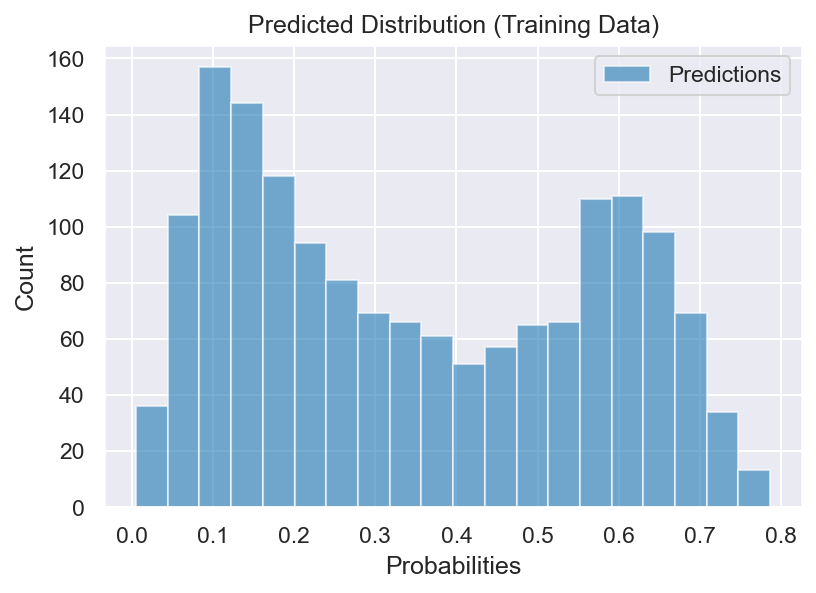

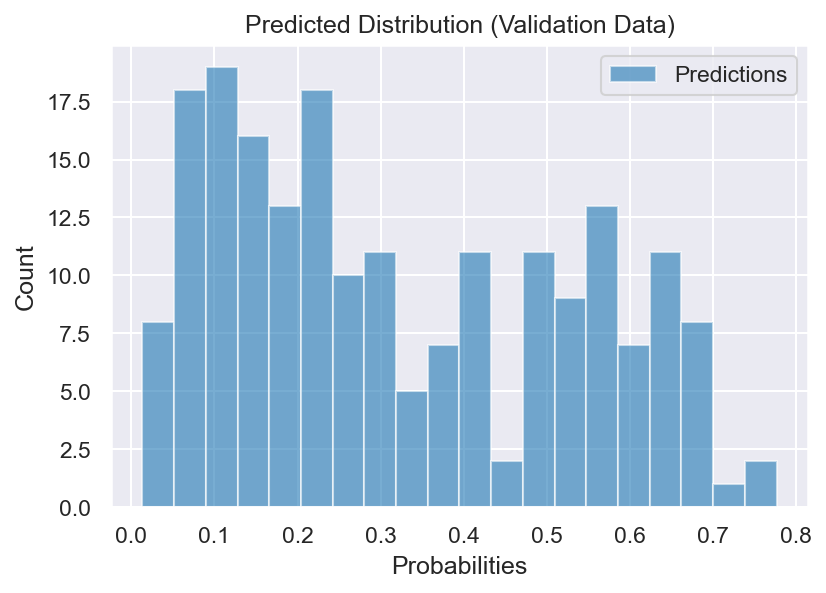

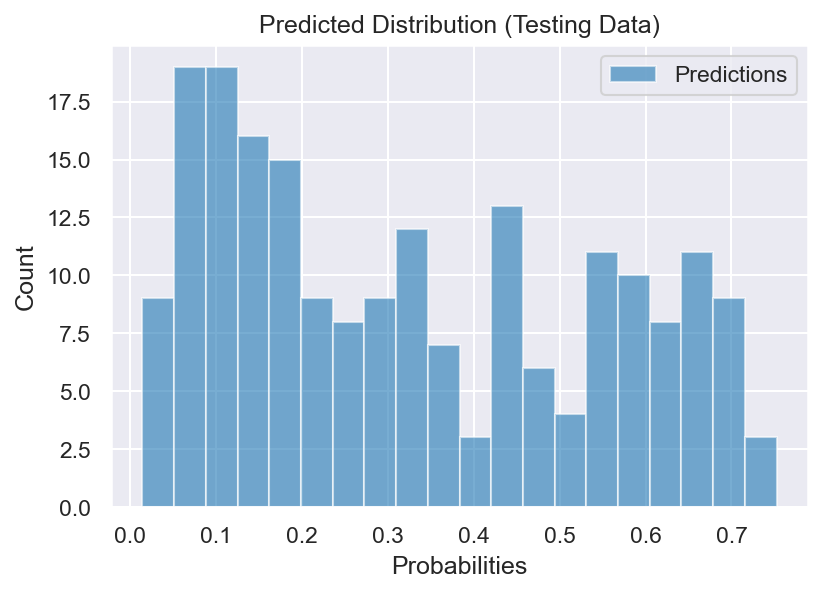

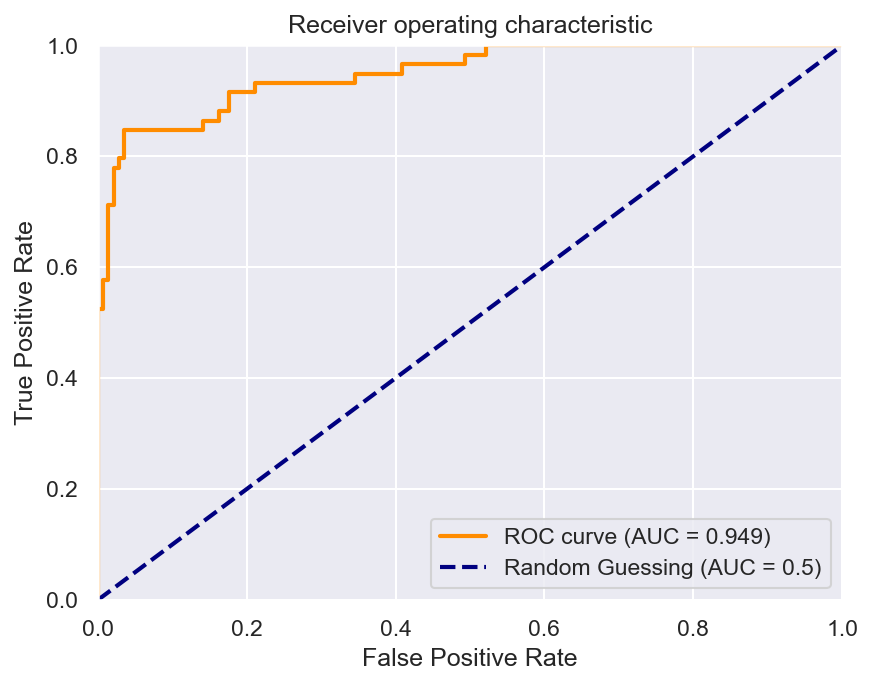

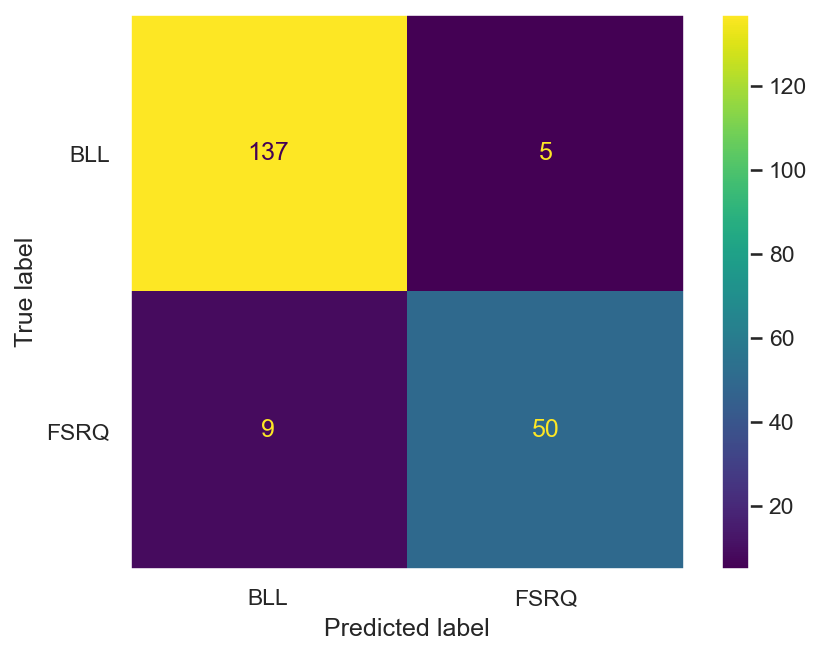

              precision    recall  f1-score   support

           0      0.938     0.965     0.951       142
           1      0.909     0.847     0.877        59

    accuracy                          0.930       201
   macro avg      0.924     0.906     0.914       201
weighted avg      0.930     0.930     0.930       201



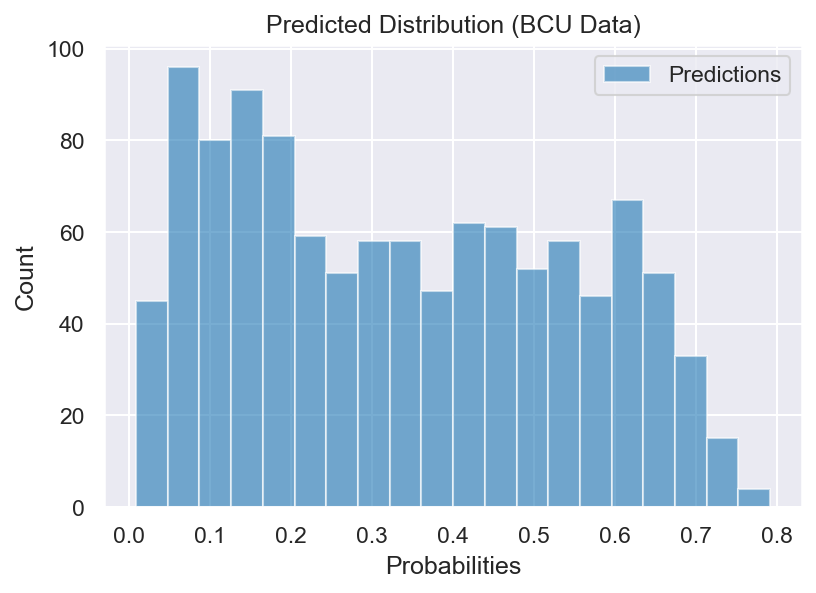

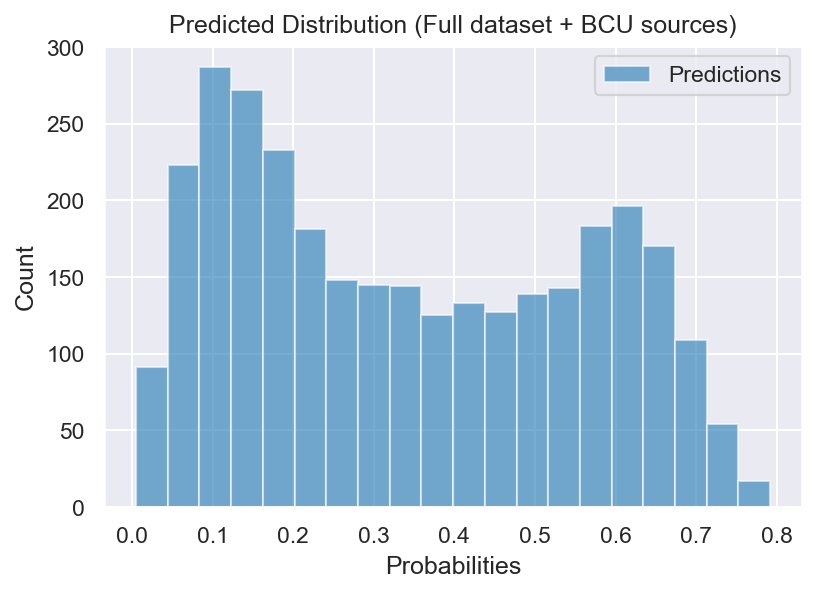

In [6]:
create_and_plot_histograms_cm_and_roc(standard_nn_classifier, X_train, 'Predicted Distribution (Training Data)', 'bias_init', [40,41], [0.1,0.9], False)
create_and_plot_histograms_cm_and_roc(standard_nn_classifier, X_val, 'Predicted Distribution (Validation Data)', 'bias_init', [40,41], [0.1,0.9], False)
create_and_plot_histograms_cm_and_roc(standard_nn_classifier, X_test, 'Predicted Distribution (Testing Data)', 'bias_init', [40,41], [0.1,0.9], True)
create_and_plot_histograms_cm_and_roc(standard_nn_classifier, bcu_samples, 'Predicted Distribution (BCU Data)', 'bias_init', [40,41], [0.1,0.9], False)
combined_X = np.vstack((X_train, X_val, X_test, bcu_samples))
create_and_plot_histograms_cm_and_roc(standard_nn_classifier, combined_X, 'Predicted Distribution (Full dataset + BCU sources)', 'bias_init', [40,41], [0.1,0.9], False)

### Supervised greedy layerwise pre-training


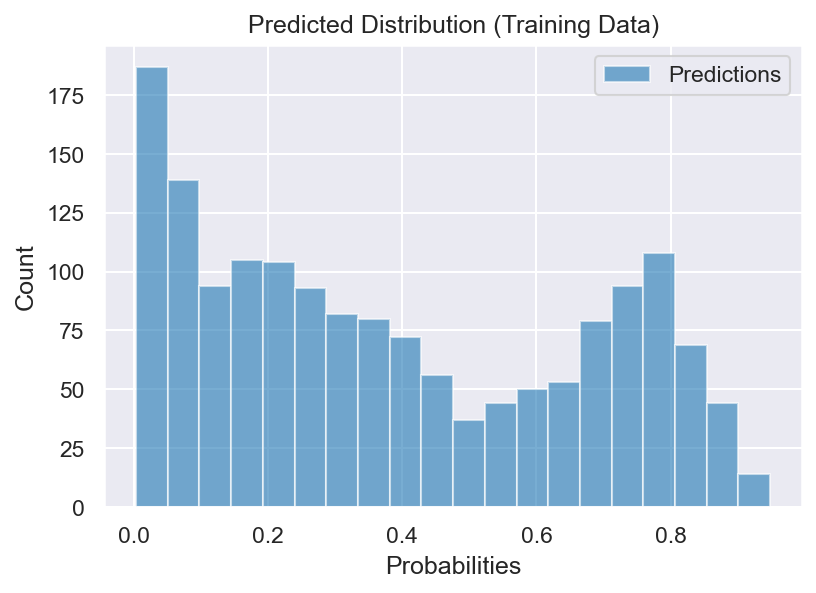

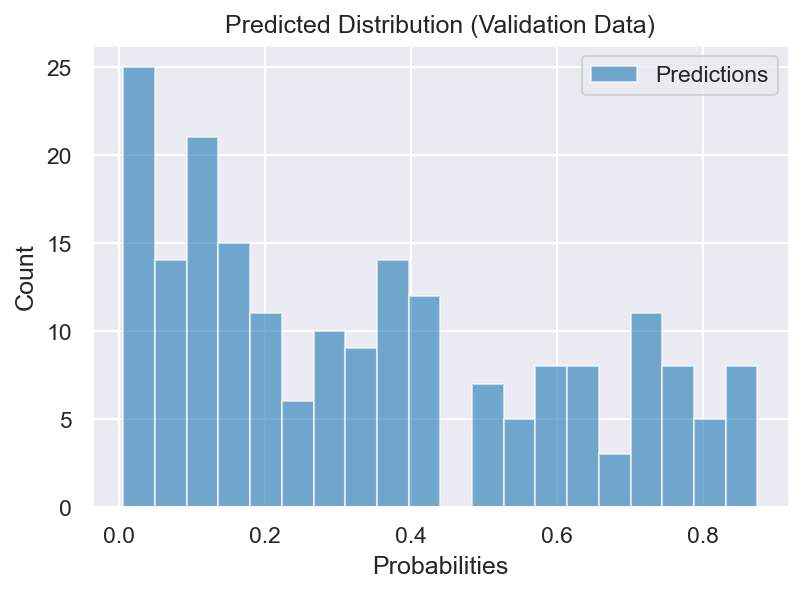

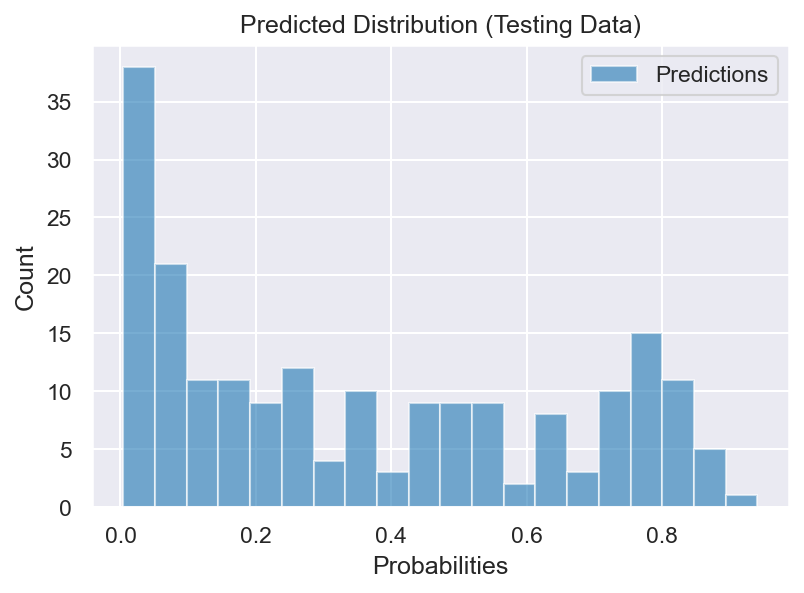

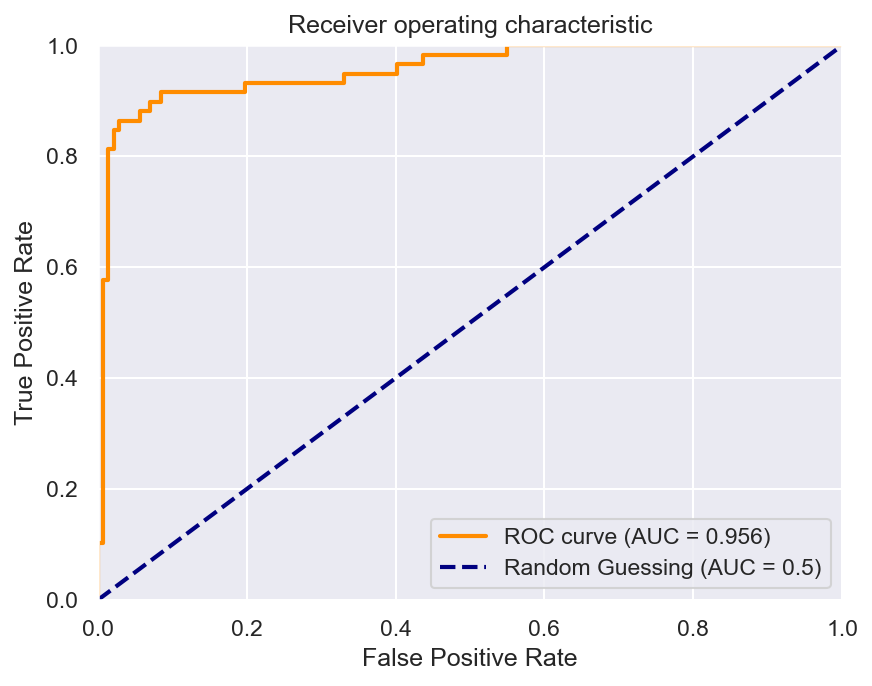

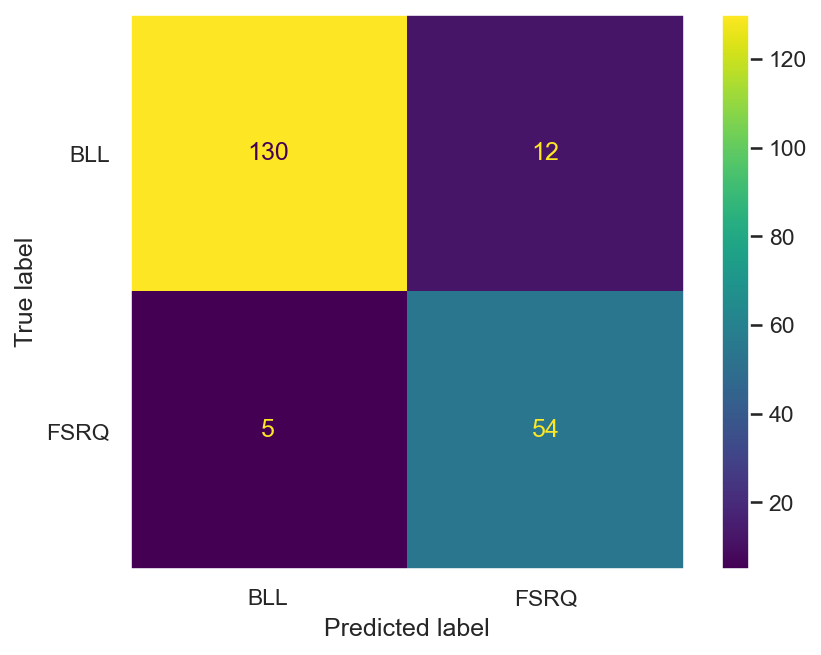

              precision    recall  f1-score   support

           0      0.963     0.915     0.939       142
           1      0.818     0.915     0.864        59

    accuracy                          0.915       201
   macro avg      0.891     0.915     0.901       201
weighted avg      0.920     0.915     0.917       201



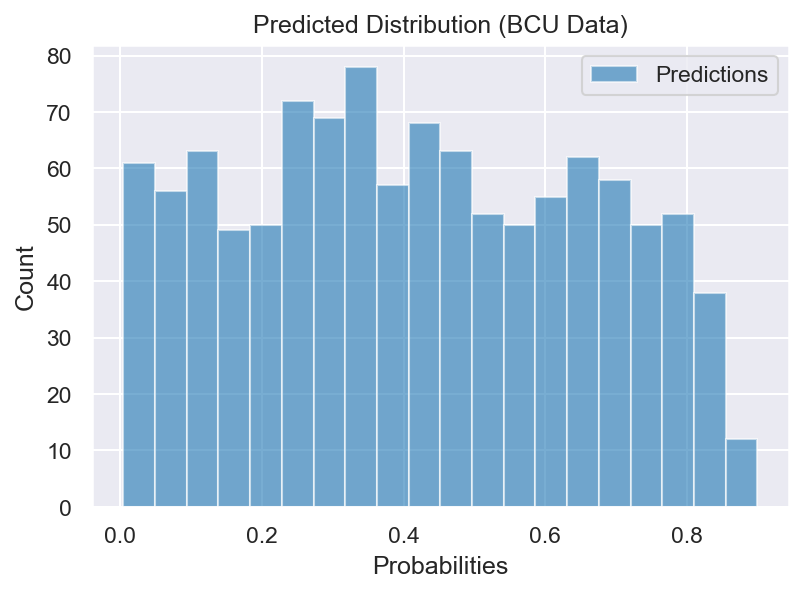

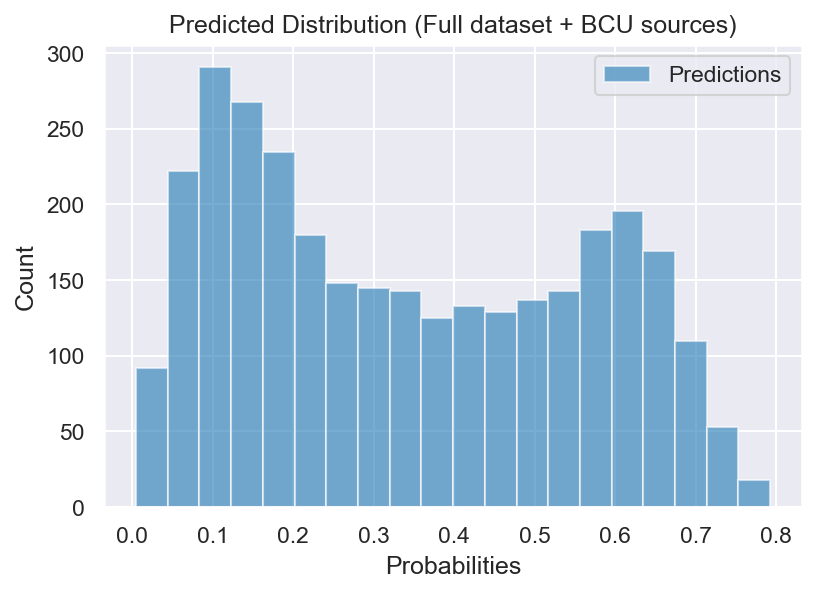

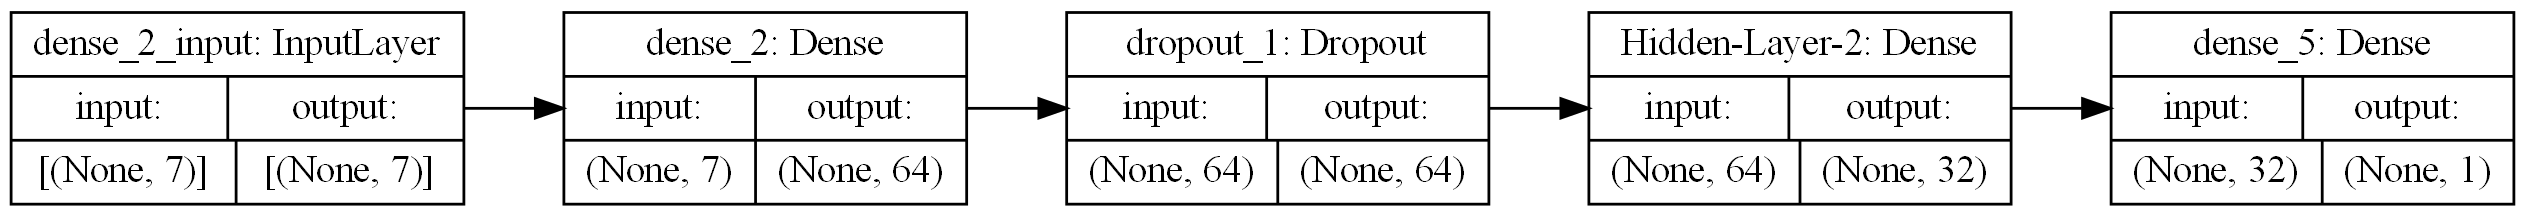

In [7]:
def remove_output_layer(model = None):
    output_layer = model.layers[-1]
    model.pop()
    for layer in model.layers:
        layer.trainable = False
    
    return model, output_layer

supervised_greedy_model = tf.keras.Sequential()
supervised_greedy_model.add(tf.keras.layers.Dense(64, activation='relu', input_shape = (X_train.shape[1],)))
supervised_greedy_model.add(tf.keras.layers.Dropout(0.5))
supervised_greedy_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

supervised_greedy_model, output_layer = remove_output_layer(model = supervised_greedy_model)
supervised_greedy_model.add(tf.keras.layers.Dense(32, activation='relu', name='Hidden-Layer-2'))
supervised_greedy_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


supervised_greedy_model, output_layer = remove_output_layer(model = supervised_greedy_model)
supervised_greedy_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

supervised_greedy_model.load_weights('./greedy_ckpts/weights_epoch_43.h5')



create_and_plot_histograms_cm_and_roc(supervised_greedy_model, X_train, 'Predicted Distribution (Training Data)', 'greedy', None, None, False)
create_and_plot_histograms_cm_and_roc(supervised_greedy_model, X_val, 'Predicted Distribution (Validation Data)', 'greedy', None, None, False)
create_and_plot_histograms_cm_and_roc(supervised_greedy_model, X_test, 'Predicted Distribution (Testing Data)', 'greedy', None, None, True)
create_and_plot_histograms_cm_and_roc(supervised_greedy_model, bcu_samples, 'Predicted Distribution (BCU Data)', 'greedy', None, None, False)
combined_X = np.vstack((X_train, X_val, X_test, bcu_samples))
create_and_plot_histograms_cm_and_roc(standard_nn_classifier, combined_X, 'Predicted Distribution (Full dataset + BCU sources)', 'greedy', None, None, False)



tf.keras.utils.plot_model(
    supervised_greedy_model,
    to_file="supervised_greedy.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=200
)

### Unsupervised greedy layerwise pre-training



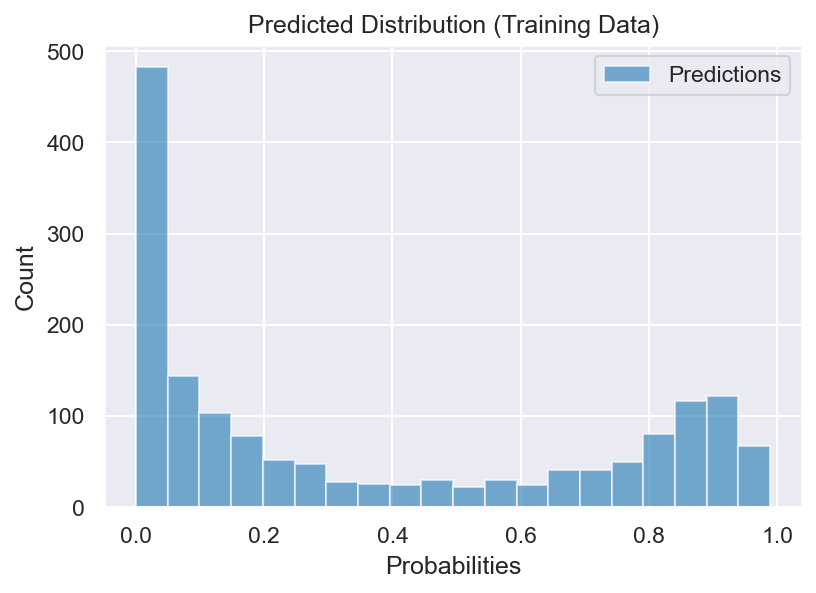

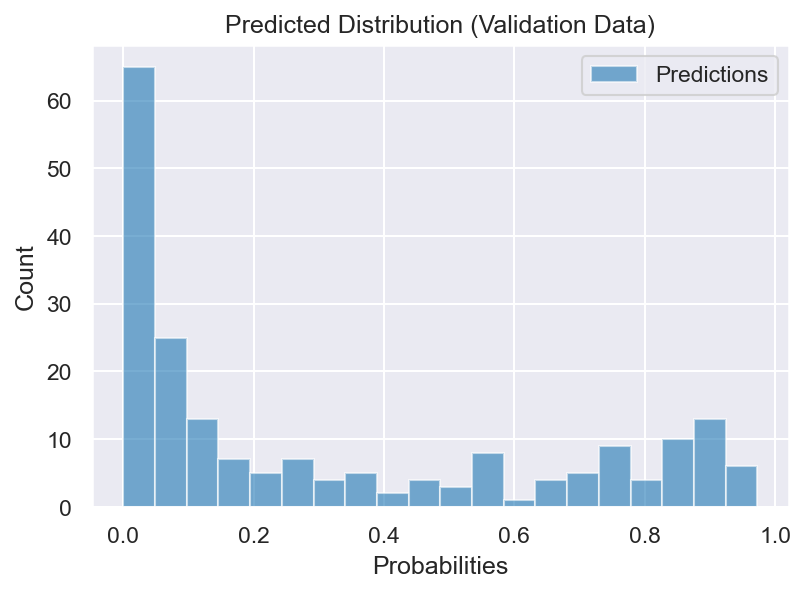

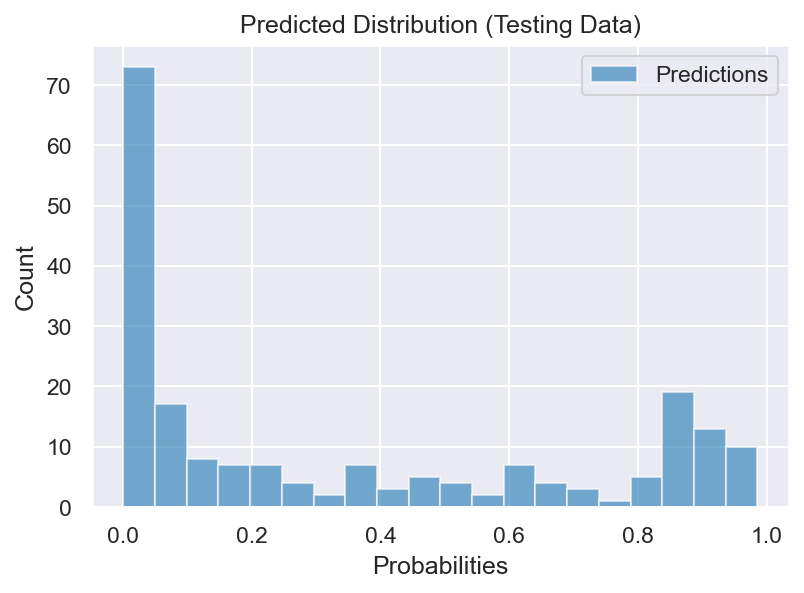

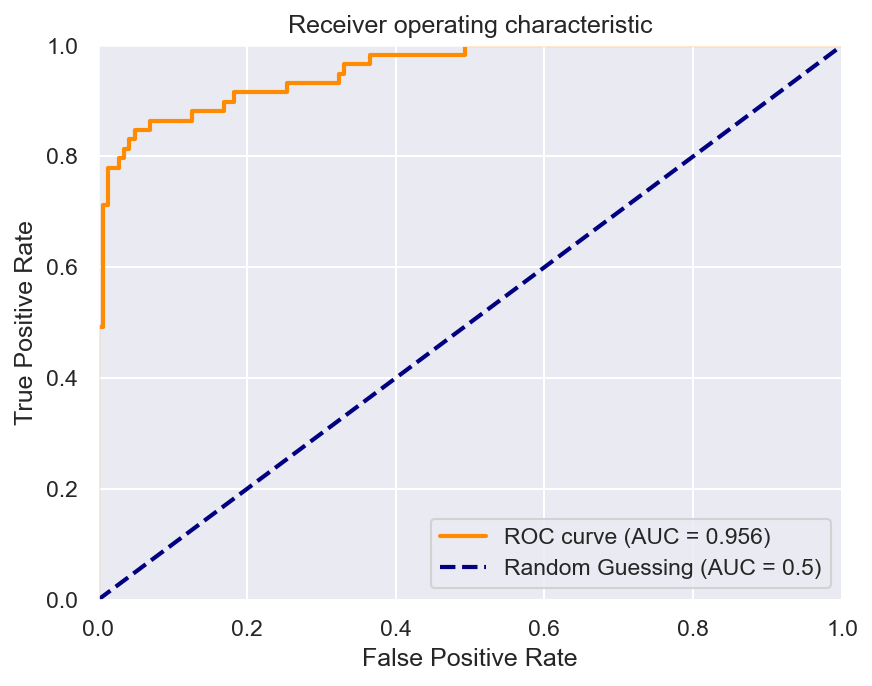

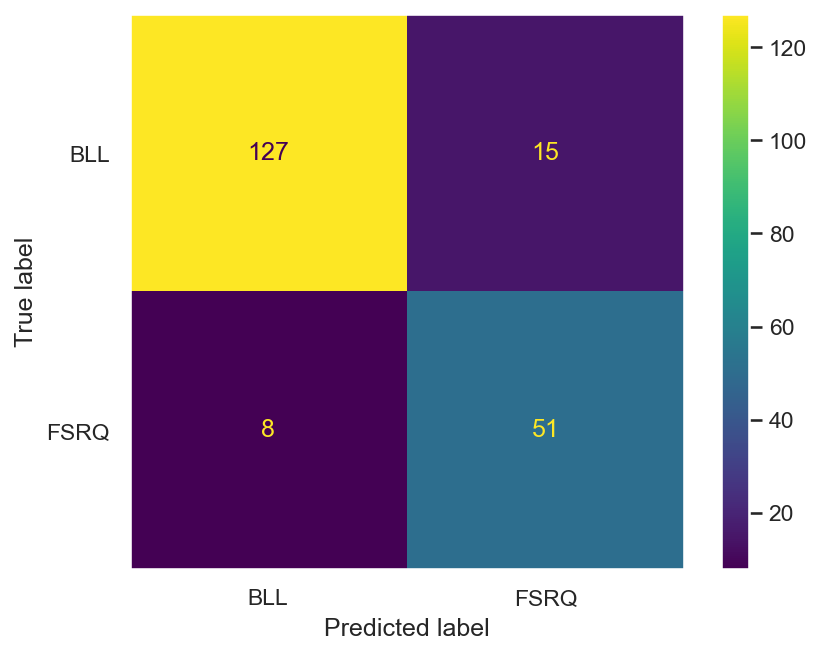

              precision    recall  f1-score   support

           0      0.941     0.894     0.917       142
           1      0.773     0.864     0.816        59

    accuracy                          0.886       201
   macro avg      0.857     0.879     0.866       201
weighted avg      0.891     0.886     0.887       201



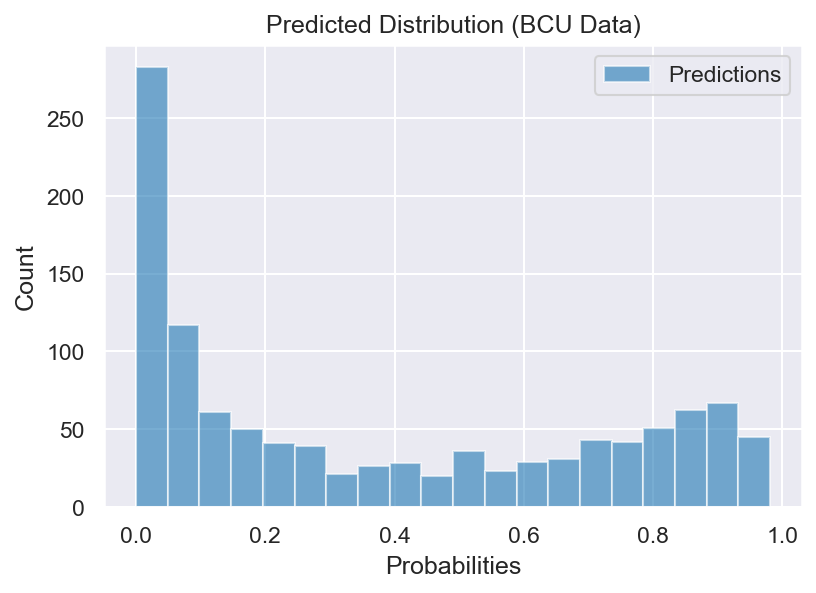

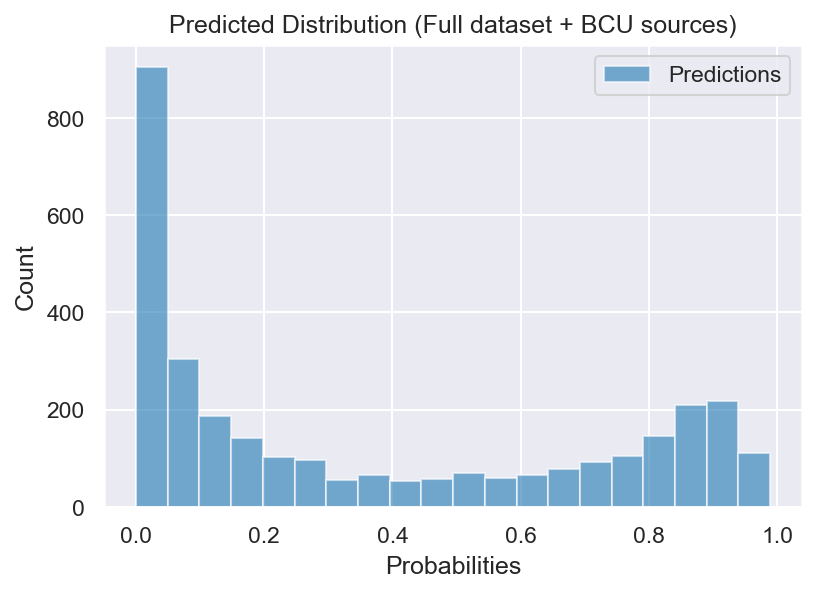

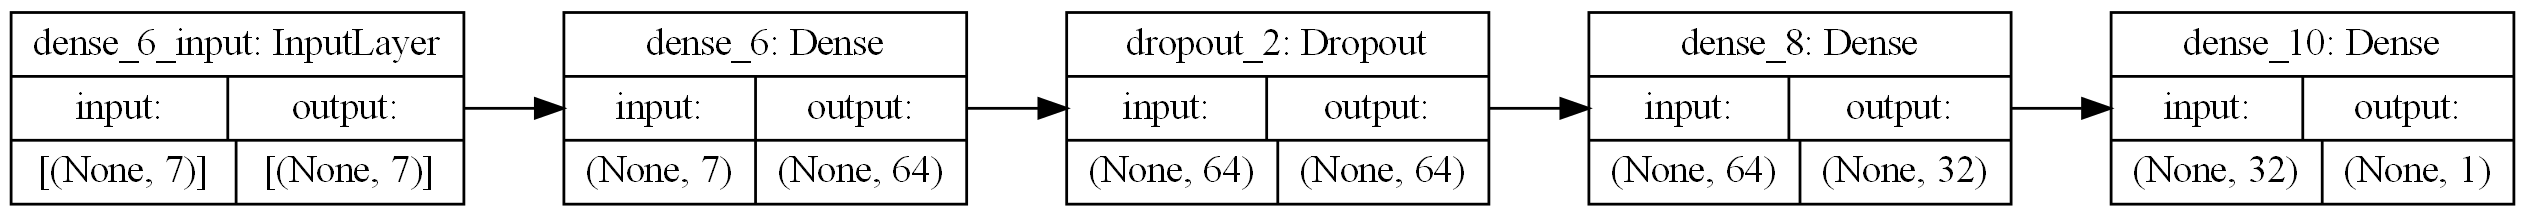

In [8]:
auto_encoder_model = tf.keras.Sequential()
auto_encoder_model.add(tf.keras.layers.Dense(64, activation='relu', input_shape = (X_train.shape[1],)))
auto_encoder_model.add(tf.keras.layers.Dropout(0.5))
auto_encoder_model.add(tf.keras.layers.Dense(X_train.shape[1], activation='linear'))

auto_encoder_model, output_layer = remove_output_layer(model=auto_encoder_model)
auto_encoder_model.add(tf.keras.layers.Dense(32, activation='relu'))
auto_encoder_model.add(tf.keras.layers.Dense(X_train.shape[1], activation='linear'))

auto_encoder_model, output_layer = remove_output_layer(model=auto_encoder_model)
auto_encoder_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

auto_encoder_model.load_weights('./greedy_ckpts_unsup/weights_epoch_699.h5')

create_and_plot_histograms_cm_and_roc(auto_encoder_model, X_train, 'Predicted Distribution (Training Data)', 'greedy', None, None, False)
create_and_plot_histograms_cm_and_roc(auto_encoder_model, X_val, 'Predicted Distribution (Validation Data)', 'greedy', None, None, False)
create_and_plot_histograms_cm_and_roc(auto_encoder_model, X_test, 'Predicted Distribution (Testing Data)', 'greedy', None, None, True)
create_and_plot_histograms_cm_and_roc(auto_encoder_model, bcu_samples, 'Predicted Distribution (BCU Data)', 'greedy', None, None, False)
combined_X = np.vstack((X_train, X_val, X_test, bcu_samples))
create_and_plot_histograms_cm_and_roc(auto_encoder_model, combined_X, 'Predicted Distribution (Full dataset + BCU sources)', 'greedy', None, None, False)



tf.keras.utils.plot_model(
    auto_encoder_model,
    to_file="unsup_greedy.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=200
)

### SSL - Autoencoder

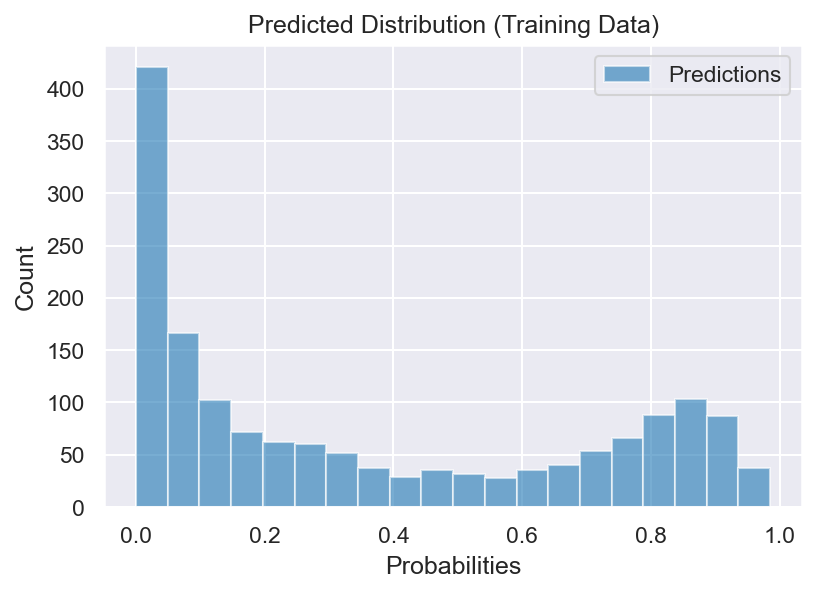

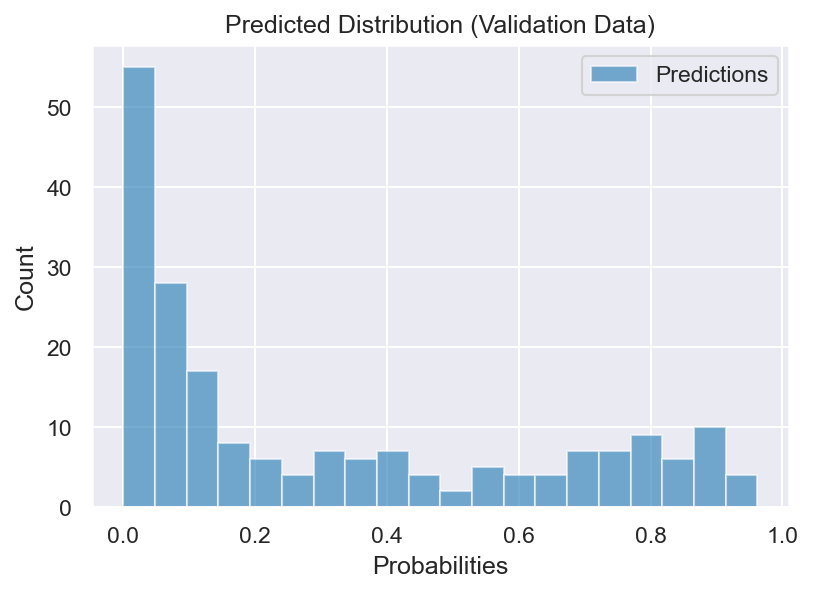

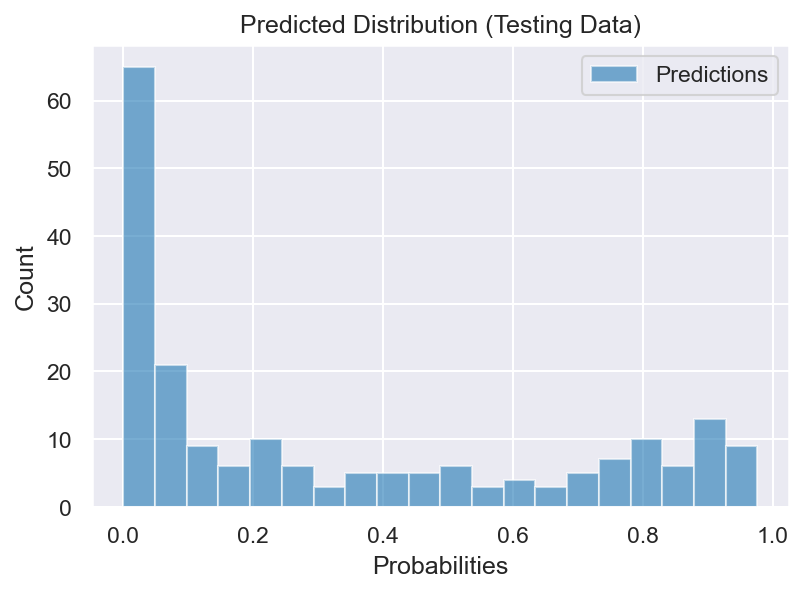

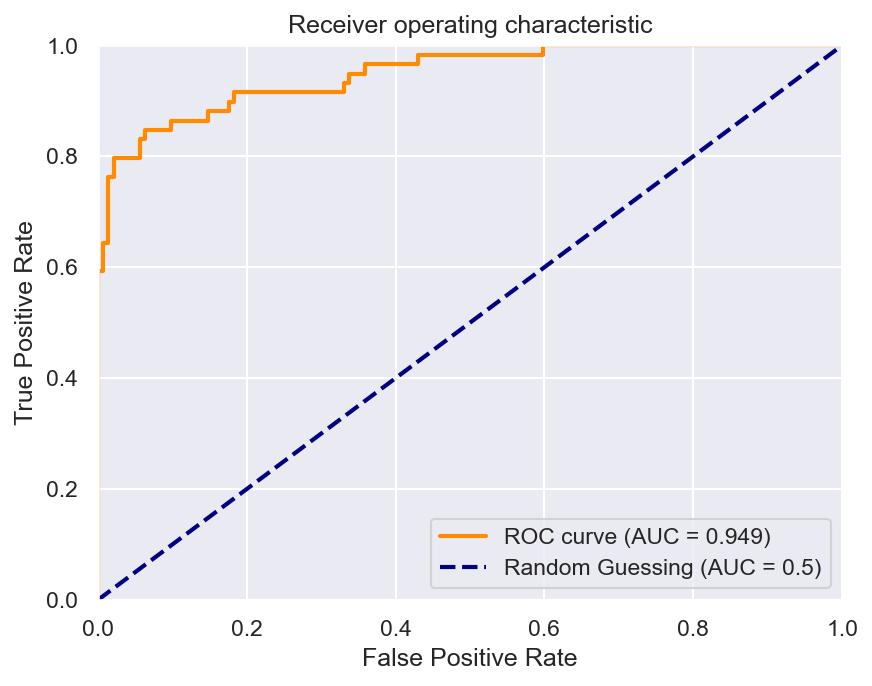

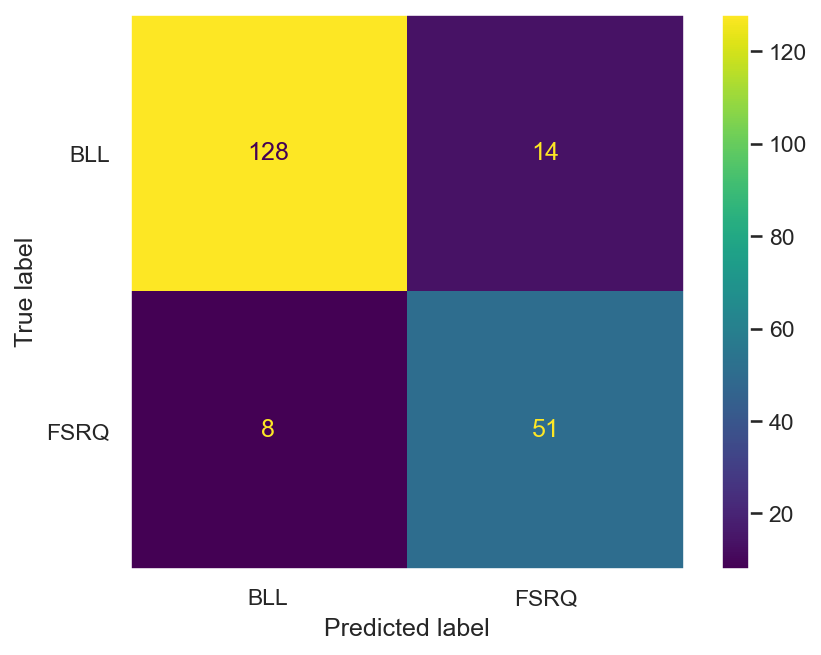

              precision    recall  f1-score   support

           0      0.941     0.901     0.921       142
           1      0.785     0.864     0.823        59

    accuracy                          0.891       201
   macro avg      0.863     0.883     0.872       201
weighted avg      0.895     0.891     0.892       201



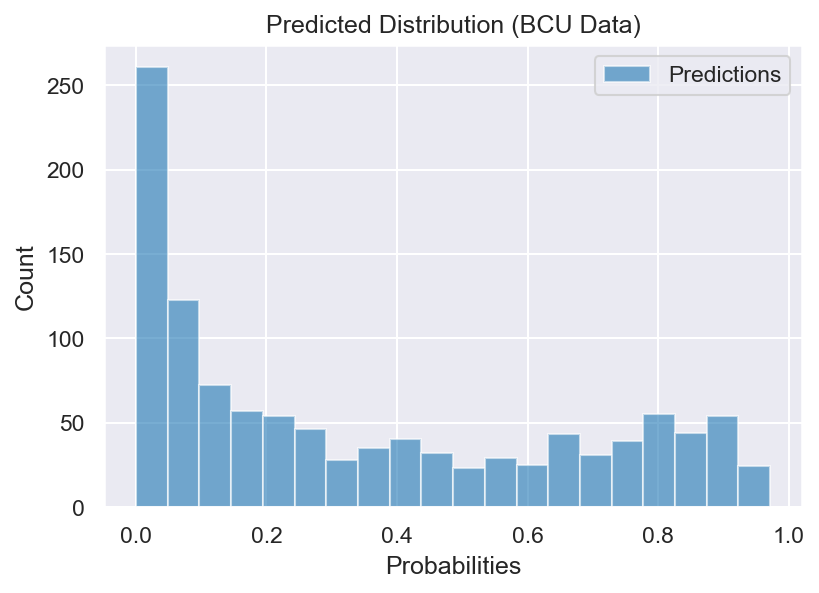

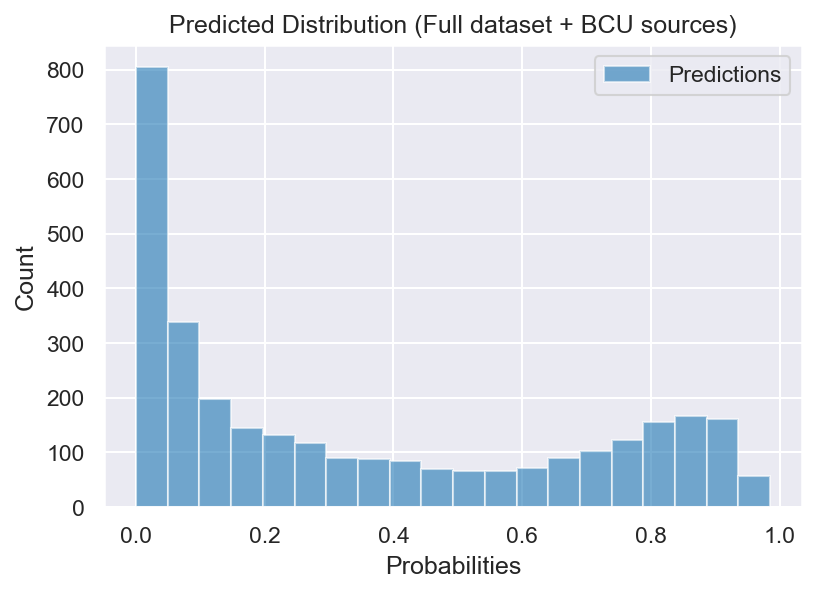

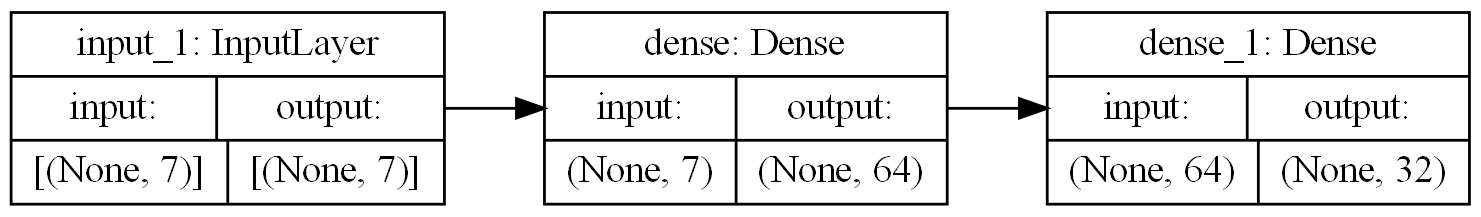

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np

# Define the self-supervised model architecture
input_layer = Input(shape=(7,))
#encoder = Dense(128, activation='relu')(input_layer)
encoder = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoder)
decoder = Dense(64, activation='relu')(encoded)
#decoder = Dense(128, activation='relu')(decoder)
decoded = Dense(7, activation='linear')(decoder)  # Reconstruction layer

# Create the encoder model (used for self-supervised task)
encoder_model = Model(inputs=input_layer, outputs=encoded)

# Create the full self-supervised model (including reconstruction loss)
self_supervised_model = Model(inputs=input_layer, outputs=decoded)

# Compile the self-supervised model with a loss function (reconstruction loss)
self_supervised_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the self-supervised model on the data
encoder_model.load_weights('./ssl_encoder.h5')

# Extract encoded features from the encoder model
encoded_features_train = encoder_model.predict(X_train)
encoded_features_val = encoder_model.predict(X_val)
encoded_features_test = encoder_model.predict(X_test)
encoded_features_bcu = encoder_model.predict(bcu_samples)
enocded_features_combined  = np.vstack((encoded_features_train, encoded_features_val, encoded_features_test, encoded_features_bcu))

# Now you can use the encoded features as inputs for a classification head
classification_input_layer = Input(shape=(32,))  # Use the appropriate size of encoded features
classification_output_layer = Dense(1, activation='sigmoid')(classification_input_layer)

classification_model = Model(inputs=classification_input_layer, outputs=classification_output_layer)
classification_model.load_weights('./ssl_ckpt_no_dropout/weights_epoch_680.h5')

create_and_plot_histograms_cm_and_roc(classification_model, encoded_features_train , 'Predicted Distribution (Training Data)', 'ssl', None, None, False)
create_and_plot_histograms_cm_and_roc(classification_model, encoded_features_val, 'Predicted Distribution (Validation Data)', 'ssl', None, None, False)
create_and_plot_histograms_cm_and_roc(classification_model, encoded_features_test, 'Predicted Distribution (Testing Data)', 'ssl', None, None, True)
create_and_plot_histograms_cm_and_roc(classification_model, encoded_features_bcu, 'Predicted Distribution (BCU Data)', 'ssl', None, None, False)
create_and_plot_histograms_cm_and_roc(classification_model, enocded_features_combined, 'Predicted Distribution (Full dataset + BCU sources)', 'ssl', None, None, False)

tf.keras.utils.plot_model(
    encoder_model,
    to_file="ssl_encoder.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=200
)



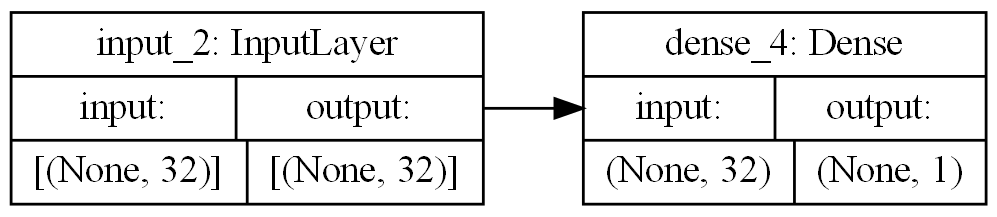

In [10]:
tf.keras.utils.plot_model(
    classification_model,
    to_file="ssl_encoder_classifier.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=200
)

### SSL - Contrastive

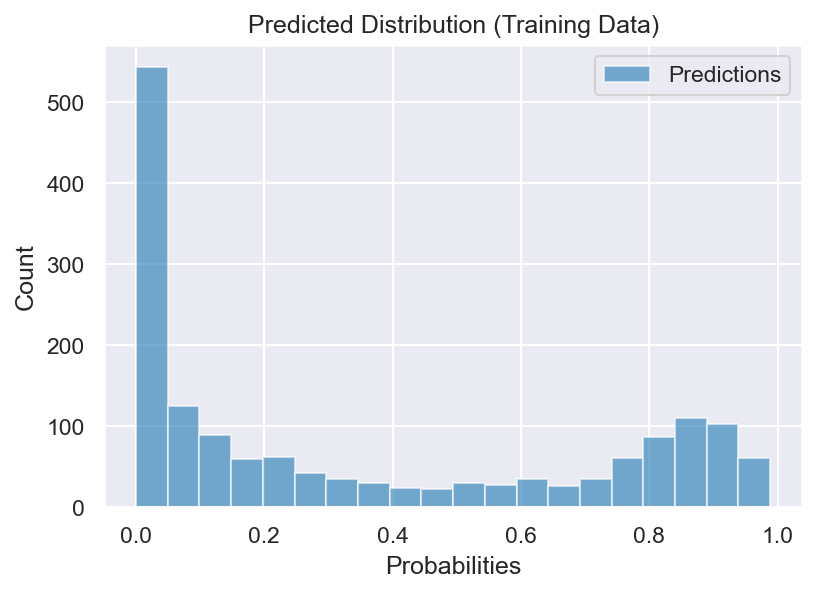

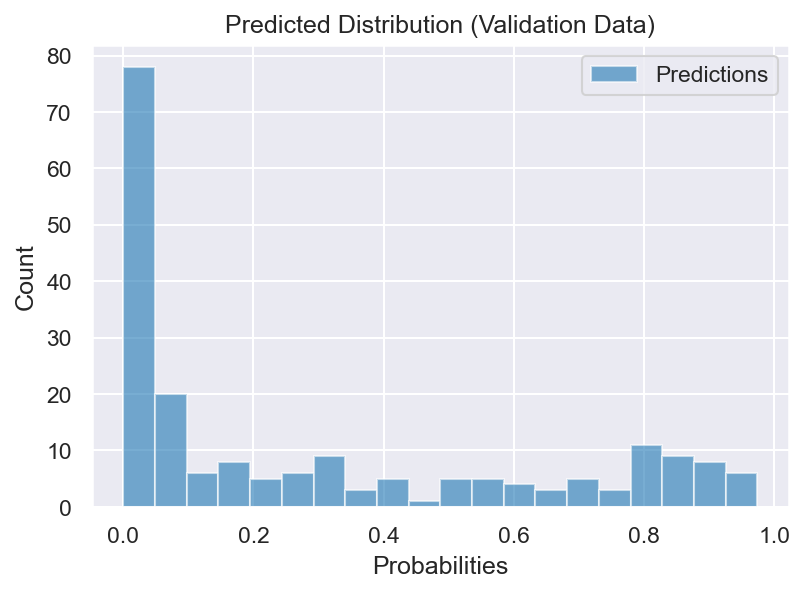

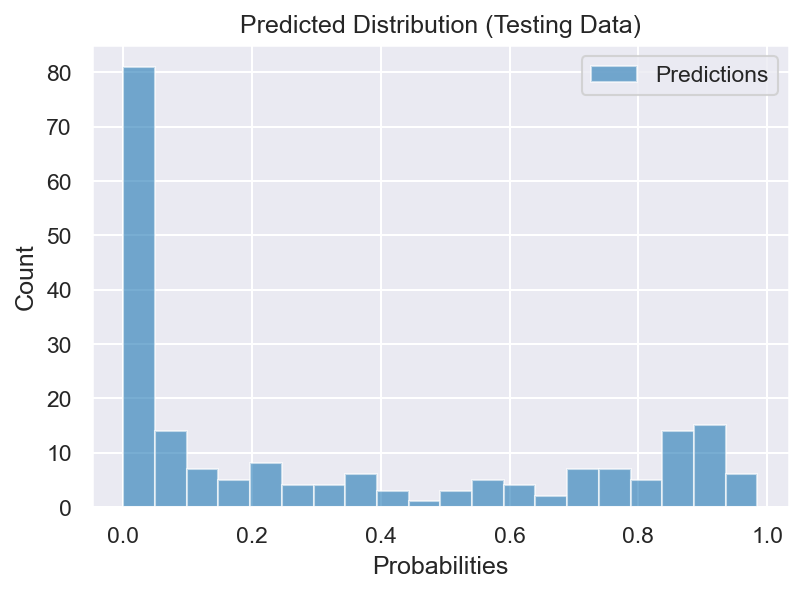

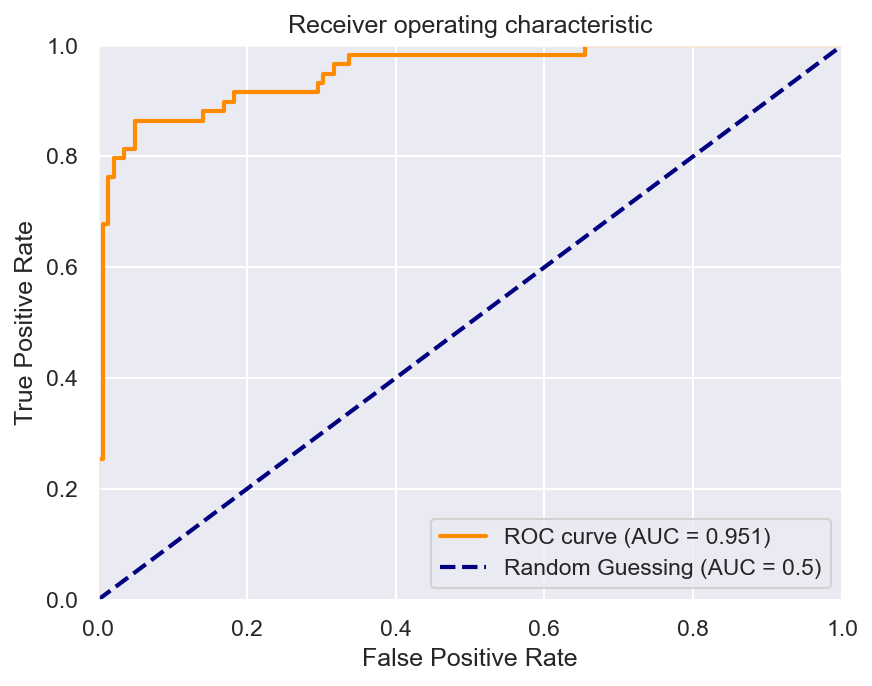

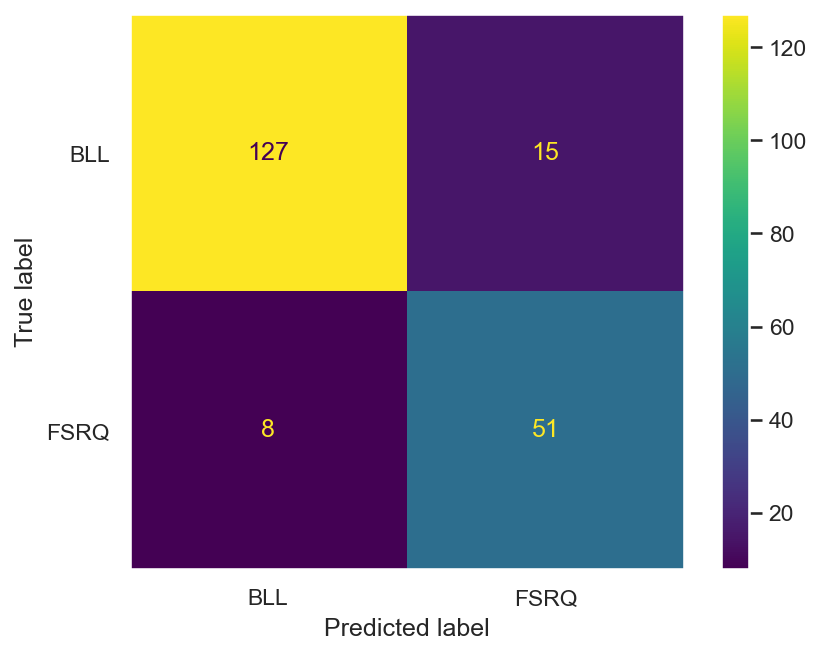

              precision    recall  f1-score   support

           0      0.941     0.894     0.917       142
           1      0.773     0.864     0.816        59

    accuracy                          0.886       201
   macro avg      0.857     0.879     0.866       201
weighted avg      0.891     0.886     0.887       201



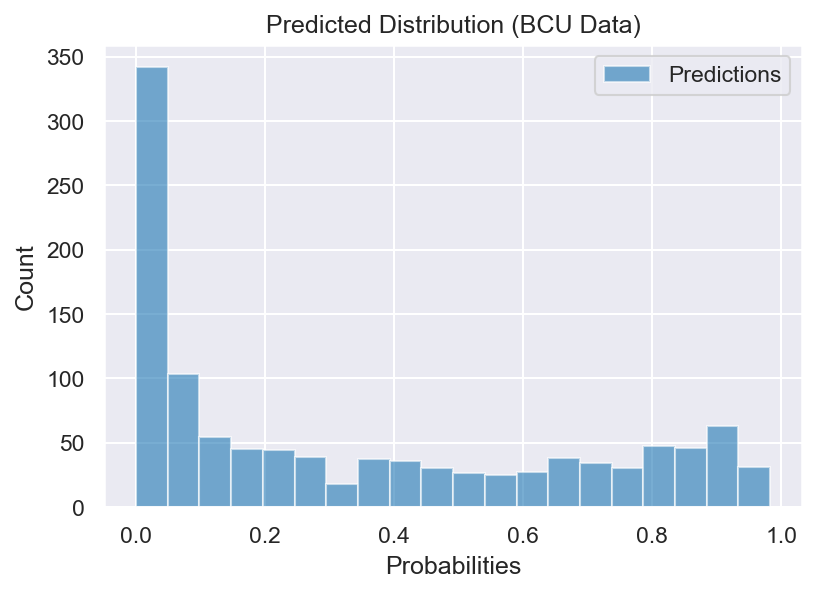

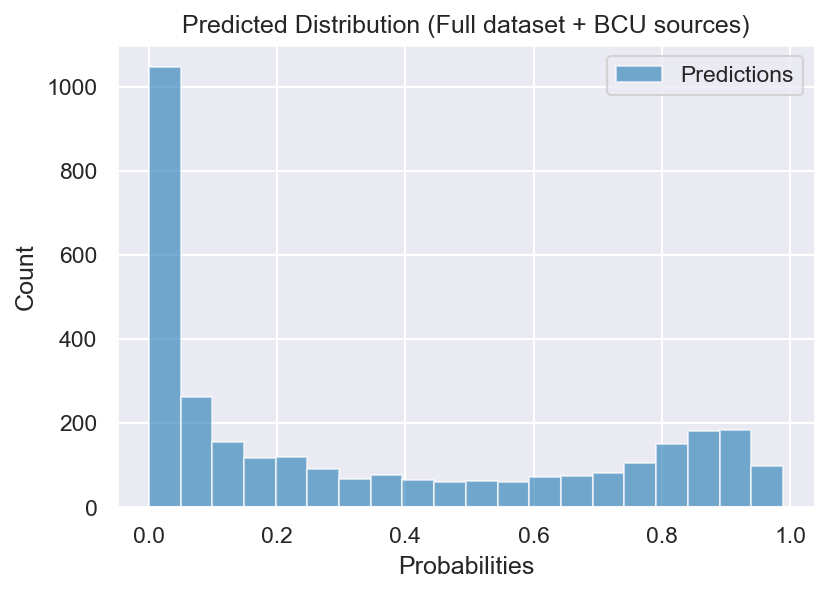

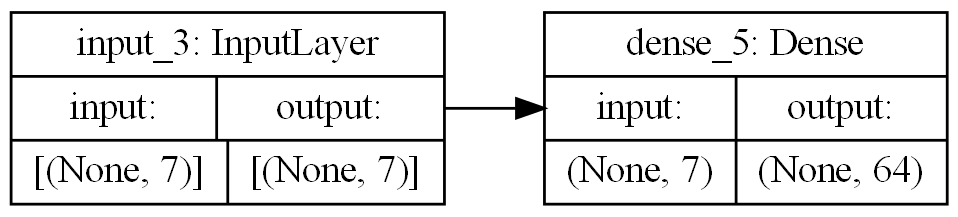

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np


# Create pairs of data samples
def create_pairs(data, labels):
    pairs, pair_labels = [], []
    num_samples = data.shape[0]
    for i in range(num_samples):
        positive_idx = np.where(labels == labels[i])[0]
        negative_idx = np.where(labels != labels[i])[0]

        positive_sample = data[np.random.choice(positive_idx)]
        negative_sample = data[np.random.choice(negative_idx)]

        pairs.append([data[i], positive_sample])
        pair_labels.append(1)  # Positive pair

        pairs.append([data[i], negative_sample])
        pair_labels.append(0)  # Negative pair

    return np.array(pairs), np.array(pair_labels)

pairs_train, pair_labels_train = create_pairs(X_train, y_train)
pairs_val, pair_labels_val = create_pairs(X_val, y_val)

# Define the contrastive classification model architecture
input_a = Input(shape=(7,))
input_b = Input(shape=(7,))
shared_dense = Dense(64, activation='relu')


encoded_a = shared_dense(input_a)
encoded_b = shared_dense(input_b)

merged = Concatenate()([encoded_a, encoded_b])
output_layer = Dense(1, activation='sigmoid')(merged)

contrastive_model = Model(inputs=[input_a, input_b], outputs=output_layer)
feature_extraction_model = Model(inputs=contrastive_model.input[0], outputs=encoded_a)  # Use one branch as feature extractor
feature_extraction_model.load_weights('./ssl_contrastive.h5')


encoded_features_train = feature_extraction_model.predict(X_train)
encoded_features_val = feature_extraction_model.predict(X_val)
encoded_features_test = feature_extraction_model.predict(X_test)
encoded_features_bcu = feature_extraction_model.predict(bcu_samples)
enocded_features_combined  = np.vstack((encoded_features_train, encoded_features_val, encoded_features_test, encoded_features_bcu))

# Build a classification model
classification_input_layer = Input(shape=(64,))  # Adjust the input shape to match the size of the extracted features
classification_output_layer = Dense(1, activation='sigmoid')(classification_input_layer)
classification_model = Model(inputs=classification_input_layer, outputs=classification_output_layer)
classification_model.load_weights('./ssl_contrastive_ckpt/weights_epoch_890.h5')


create_and_plot_histograms_cm_and_roc(classification_model, encoded_features_train , 'Predicted Distribution (Training Data)', 'ssl', None, None, False)
create_and_plot_histograms_cm_and_roc(classification_model, encoded_features_val, 'Predicted Distribution (Validation Data)', 'ssl', None, None, False)
create_and_plot_histograms_cm_and_roc(classification_model, encoded_features_test, 'Predicted Distribution (Testing Data)', 'ssl', None, None, True)
create_and_plot_histograms_cm_and_roc(classification_model, encoded_features_bcu, 'Predicted Distribution (BCU Data)', 'ssl', None, None, False)
create_and_plot_histograms_cm_and_roc(classification_model, enocded_features_combined, 'Predicted Distribution (Full dataset + BCU sources)', 'ssl', None, None, False)


tf.keras.utils.plot_model(
    feature_extraction_model,
    to_file="ssl_contrastive_feature_extractor.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=200
)


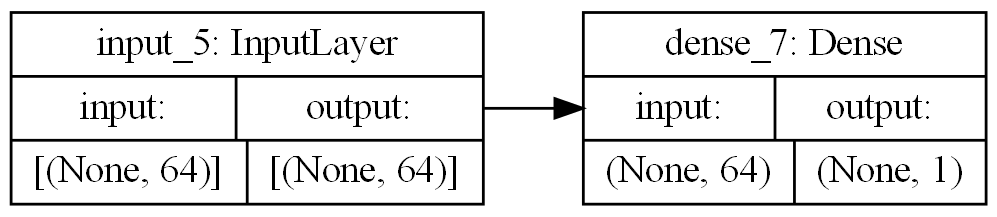

In [12]:
tf.keras.utils.plot_model(
    classification_model,
    to_file="ssl_contrastive_classifier.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=200
)